In [1]:
import geopandas as gpd
import rasterio
from rasterio.mask import mask
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Paths to shapefiles and raster files
shapefile_paths = {
    "Snow Field": "Snow_field_threshold_w_lidar_difference.shp",
    "Rock Glacier": "NPS_rock_glacier.shp",
    "Clean Glacier": "teton_outline_final.shp"
}

raster_paths = {
    "1967-2014": {
        "Snow Field": "Elevation_Change_SnowField_1967_2014_local_hyp.tif",
        "Rock Glacier": "Elevation_Change_RockGlacier_1967_2014_local_hyp.tif",
        "Clean Glacier": "Elevation_Change_CleanGlacier_1967_2014_local_hyp.tif"
    },
    "2014-2022": {
        "Snow Field": "Elevation_Change_SnowField_2022_new.tif",
        "Rock Glacier": "Elevation_Change_RockGlacier_2022_new.tif",
        "Clean Glacier": "Elevation_Change_CleanGlacier_2022_new.tif"
    }
}

# Duration in years for each interval
year_diff = {
    "1967-2014": 47,
    "2014-2022": 8
}

# List to store data for violin plot
violin_data = []

# Loop over time periods and categories
for period, rasters in raster_paths.items():
    for category, raster_fp in rasters.items():
        shapefile_fp = shapefile_paths[category]
        gdf = gpd.read_file(shapefile_fp)

        with rasterio.open(raster_fp) as src:
            raster_crs = src.crs
            if gdf.crs.to_epsg() != raster_crs.to_epsg():
                gdf = gdf.to_crs(raster_crs.to_epsg())

            for _, row in gdf.iterrows():
                geom = [row["geometry"]]
                try:
                    clipped, _ = mask(src, geom, crop=True)
                    array = clipped[0].astype(np.float32)
                    array[array == src.nodata] = np.nan
                    array = array / year_diff[period]
                    valid_values = array[~np.isnan(array)]
                    if valid_values.size > 0:
                        poly_mean = np.mean(valid_values)
                        violin_data.append({
                            "Category": f"{category} ({period})",
                            "Elevation Change Rate (m/year)": poly_mean
                        })
                except Exception:
                    continue

# Create DataFrame for plotting
df = pd.DataFrame(violin_data)


In [2]:
# Convert to DataFrame 
summary_df = pd.DataFrame(df)


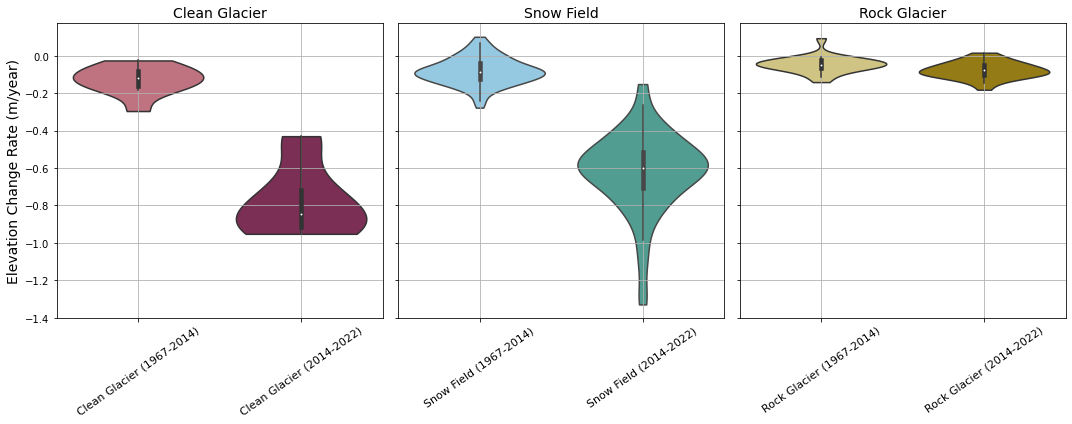


Median Elevation Change Rates (m/year) by Category:
Category
Clean Glacier (1967-2014)   -0.119
Clean Glacier (2014-2022)   -0.844
Rock Glacier (1967-2014)    -0.050
Rock Glacier (2014-2022)    -0.078
Snow Field (1967-2014)      -0.087
Snow Field (2014-2022)      -0.599
Name: Elevation Change Rate (m/year), dtype: float64


In [3]:

# Custom colors for each group
custom_palette = {
    "Snow Field (1967-2014)": "#88CCEE",
    "Snow Field (2014-2022)": "#44AA99",
    "Rock Glacier (1967-2014)": "#DDCC77",
    "Rock Glacier (2014-2022)": "#AA8800",
    "Clean Glacier (1967-2014)": "#CC6677",
    "Clean Glacier (2014-2022)": "#882255",
}

# Group definitions in desired order
groupings = [
    ("Clean Glacier", ["Clean Glacier (1967-2014)", "Clean Glacier (2014-2022)"]),
    ("Snow Field", ["Snow Field (1967-2014)", "Snow Field (2014-2022)"]),
    ("Rock Glacier", ["Rock Glacier (1967-2014)", "Rock Glacier (2014-2022)"]),
]

# Create 3 subplots side by side with shared y-axis
fig, axes = plt.subplots(1, 3, figsize=(15, 6), sharey=True)

for ax, (label, categories) in zip(axes, groupings):
    subset = df[df['Category'].isin(categories)]
    
    sns.violinplot(
        x="Category",
        y="Elevation Change Rate (m/year)",
        data=subset,
        palette={cat: custom_palette[cat] for cat in categories},
        order=categories,
        cut=0,
        scale="width",
        inner="box",
        ax=ax
    )

    ax.set_title(label, fontsize=14)
    ax.set_xlabel("")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=35, fontsize=11)
    ax.grid(True)

# Set y-axis label on the far left
axes[0].set_ylabel("Elevation Change Rate (m/year)", fontsize=14)
for ax in axes[1:]:
    ax.set_ylabel("")

plt.tight_layout()
plt.show()

# Print median elevation change rate per category
category_medians = df.groupby("Category")["Elevation Change Rate (m/year)"].median()
print("\nMedian Elevation Change Rates (m/year) by Category:")
print(category_medians.round(3))  # Optional: round for cleaner output


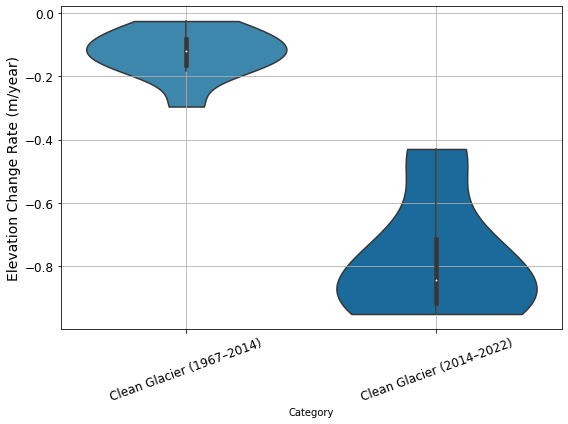


Median Elevation Change Rates (m/year) by Category:
Category
Clean Glacier (1967–2014)   -0.119
Clean Glacier (2014–2022)   -0.844
Name: Elevation Change Rate (m/year), dtype: float64


In [4]:
# Define shapefile and raster paths for Clean Glacier only
clean_glacier_shapefile = "teton_outline_final.shp"
clean_raster_paths = {
    "Clean Glacier (1967–2014)": "Elevation_Change_CleanGlacier_1967_2014_local_hyp.tif", 
    "Clean Glacier (2014–2022)": "Elevation_Change_CleanGlacier_2022_new.tif"
}
year_diff = {
    "Clean Glacier (1967–2014)": 47,
    "Clean Glacier (2014–2022)": 8
}



# Store violin data
violin_data = []

# Load shapefile
gdf = gpd.read_file(clean_glacier_shapefile)

# Loop over each time period and raster
for label, raster_fp in clean_raster_paths.items():
    with rasterio.open(raster_fp) as src:
        # Reproject shapefile if needed
        if gdf.crs.to_epsg() != src.crs.to_epsg():
            gdf = gdf.to_crs(src.crs.to_epsg())

        for _, row in gdf.iterrows():
            geom = [row["geometry"]]
            try:
                clipped, _ = mask(src, geom, crop=True)
                array = clipped[0].astype(np.float32)
                array[array == src.nodata] = np.nan
                array = array / year_diff[label]
                valid_values = array[~np.isnan(array)]
                if valid_values.size > 0:
                    poly_mean= np.mean(valid_values)
                    violin_data.append({
                        "Category": label,
                        "Elevation Change Rate (m/year)": poly_mean
                    })
            except Exception:
                continue

# Create DataFrame
df = pd.DataFrame(violin_data)

# Define custom colors
custom_palette = {
    "Clean Glacier (1967–2014)": "#2b8cbe",
    "Clean Glacier (2014–2022)": "#0570b0"
}

# Plot
plt.figure(figsize=(8, 6))
sns.violinplot(
    x="Category",
    y="Elevation Change Rate (m/year)",
    data=df,
    palette=custom_palette,
    cut=0,
    scale="width",
    inner="box"
)
plt.ylabel("Elevation Change Rate (m/year)", fontsize=14)
plt.xticks(rotation=20, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

# Print median elevation change rate per category
category_medians = df.groupby("Category")["Elevation Change Rate (m/year)"].median()
print("\nMedian Elevation Change Rates (m/year) by Category:")
print(category_medians.round(3))


df_clean = pd.DataFrame(violin_data)
# Save clean glacier medians as arrays for final plot integration
clean_1967_2014 = df_clean[df_clean['Category'] == 'Clean Glacier (1967–2014)']["Elevation Change Rate (m/year)"].values
clean_2014_2022 = df_clean[df_clean['Category'] == 'Clean Glacier (2014–2022)']["Elevation Change Rate (m/year)"].values



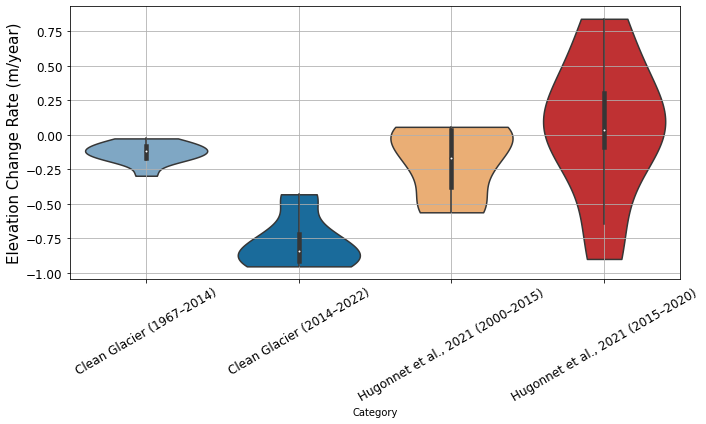

In [5]:
# Load Hugonnet CSV data
hugonnet_df = pd.read_csv("D:/Desktop/Teton/Teton DEMS for arcgis/2014 and 2022 Lidar/hugonnet_glacier_compariaion/dh_02_rgi60_pergla_rates.csv")


# Define RGI IDs for the Teton glaciers
rgi_names = {
    'Teton': 'RGI60-02.14767',
    'Teepe': 'RGI60-02.14771',
    'Middle Teton': 'RGI60-02.14758',
    'Schoolroom': 'RGI60-02.14731',
    'Triple West': 'RGI60-02.14825',
    'Triple Middle': 'RGI60-02.14824',
    'Triple East': 'RGI60-02.14822',
    'Skillet': 'RGI60-02.14818',
    'Falling Ice': 'RGI60-02.14816',
    'Petersen': 'RGI60-02.14784',
    'Unnamed': 'RGI60-02.14684'
}
rgi_ids = list(rgi_names.values())

# Filter and parse dates
hugonnet_df = hugonnet_df[hugonnet_df['rgiid'].isin(rgi_ids)].copy()
hugonnet_df[['start_date', 'end_date']] = hugonnet_df['period'].str.split('_', expand=True)
hugonnet_df['start_date'] = pd.to_datetime(hugonnet_df['start_date'])
hugonnet_df['end_date'] = pd.to_datetime(hugonnet_df['end_date'])
hugonnet_df['years'] = (hugonnet_df['end_date'] - hugonnet_df['start_date']).dt.days / 365.25
hugonnet_df['elev_change'] = hugonnet_df['dhdt'] * hugonnet_df['years']

# Combine 2000–2010 and 2010–2015
seg1 = hugonnet_df[(hugonnet_df['start_date'].dt.year == 2000) & (hugonnet_df['end_date'].dt.year == 2010)][['rgiid', 'elev_change']]
seg2 = hugonnet_df[(hugonnet_df['start_date'].dt.year == 2010) & (hugonnet_df['end_date'].dt.year == 2015)][['rgiid', 'elev_change']]
combined = pd.merge(seg1, seg2, on='rgiid', suffixes=('_00_10', '_10_15'))
combined['mean_dhdt_00_15'] = (combined['elev_change_00_10'] + combined['elev_change_10_15']) / 15
hugonnet_2000_2015 = combined['mean_dhdt_00_15'].values

# Extract 2015–2020
seg3 = hugonnet_df[(hugonnet_df['start_date'].dt.year == 2015) & (hugonnet_df['end_date'].dt.year == 2020)].copy()
seg3['mean_dhdt_15_20'] = seg3['elev_change'] / 5
hugonnet_2015_2020 = seg3.sort_values('rgiid')['mean_dhdt_15_20'].values

# Create final violin DataFrame
violin_df = pd.DataFrame({
    "Category": (["Clean Glacier (1967–2014)"] * len(clean_1967_2014)) +
                (["Clean Glacier (2014–2022)"] * len(clean_2014_2022)) +
                (["Hugonnet et al., 2021 (2000–2015)"] * len(hugonnet_2000_2015)) +
                (["Hugonnet et al., 2021 (2015–2020)"] * len(hugonnet_2015_2020)),
    "Elevation Change Rate (m/year)": np.concatenate([
        clean_1967_2014,
        clean_2014_2022,
        hugonnet_2000_2015,
        hugonnet_2015_2020
    ])
})

# Plotting
custom_palette = {
    "Clean Glacier (1967–2014)": "#74a9cf",
    "Clean Glacier (2014–2022)": "#0570b0",
    "Hugonnet et al., 2021 (2000–2015)": "#fdae61",
    "Hugonnet et al., 2021 (2015–2020)": "#d7191c"
}

plt.figure(figsize=(10, 6))
sns.violinplot(
    x="Category",
    y="Elevation Change Rate (m/year)",
    data=violin_df,
    palette=custom_palette,
    cut=0,
    scale="width",
    inner="box"
)
plt.ylabel("Elevation Change Rate (m/year)", fontsize=15)
plt.xticks(rotation=30, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()



In [6]:
# Load glacier shapefile (polygons of clean glaciers)
glacier_gdf = gpd.read_file("teton_outline_final.shp")

# Read Menounos glacier elevation change raster (in m/year)
with rasterio.open("clipped_outputs/menounos_glacier_elev_change.tif") as src:
    menounos_crs = src.crs

    # Ensure CRS match
    if glacier_gdf.crs.to_epsg() != menounos_crs.to_epsg():
        glacier_gdf = glacier_gdf.to_crs(menounos_crs.to_epsg())

    # Loop through polygons to calculate means
    means = []
    for _, row in glacier_gdf.iterrows():
        geom = [row['geometry']]
        try:
            clipped, _ = mask(src, geom, crop=True)
            array = clipped[0].astype(np.float32)
            array[array == src.nodata] = np.nan
            valid = array[~np.isnan(array)]
            if valid.size > 0:
                meand.append(np.mean(valid))
        except Exception:
            continue

# Prepare data for violin plot
violin_menounos = pd.DataFrame({
    "Category": ["Menounos et al., 2018 (2000-2018)"] * len(means),
    "Elevation Change Rate (m/year)": means
})


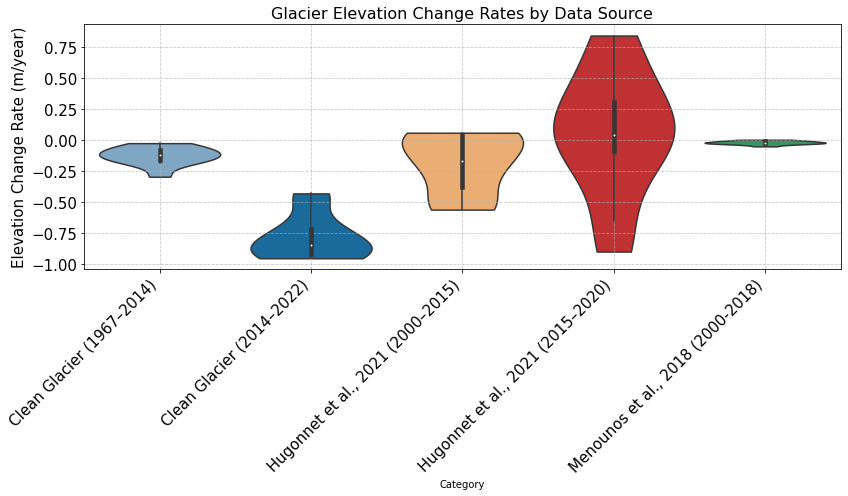

In [7]:
# --- Menounos Data Processing ---
# Load glacier shapefile (polygons of clean glaciers)
glacier_gdf = gpd.read_file("teton_outline_final.shp")

# Read Menounos glacier elevation change raster (in m/year)
menounos_means = [] # Initialize list to store means
with rasterio.open("clipped_outputs/menounos_glacier_elev_change.tif") as src:
    menounos_crs = src.crs

    # Ensure CRS match
    if glacier_gdf.crs.to_epsg() != menounos_crs.to_epsg():
        glacier_gdf = glacier_gdf.to_crs(menounos_crs.to_epsg())

    # Loop through polygons to calculate meanss
    for _, row in glacier_gdf.iterrows():
        geom = [row['geometry']]
        try:
            clipped, _ = mask(src, geom, crop=True)
            array = clipped[0].astype(np.float32)
            array[array == src.nodata] = np.nan
            valid = array[~np.isnan(array)]
            if valid.size > 0:
                menounos_means.append(np.mean(valid))
        except Exception as e:
            print(f"Skipping geometry due to error: {e}") # Print error for debugging
            continue

menounos_elev_change = np.array(menounos_means) # Convert list to numpy array

# --- Create final violin DataFrame with all datasets ---
violin_df = pd.DataFrame({
    "Category": (["Clean Glacier (1967–2014)"] * len(clean_1967_2014)) +
                (["Clean Glacier (2014–2022)"] * len(clean_2014_2022)) +
                (["Hugonnet et al., 2021 (2000–2015)"] * len(hugonnet_2000_2015)) +
                (["Hugonnet et al., 2021 (2015–2020)"] * len(hugonnet_2015_2020)) +
                (["Menounos et al., 2018 (2000-2018)"] * len(menounos_elev_change)), # New category for Menounos
    "Elevation Change Rate (m/year)": np.concatenate([
        clean_1967_2014,
        clean_2014_2022,
        hugonnet_2000_2015,
        hugonnet_2015_2020,
        menounos_elev_change # Add Menounos data
    ])
})

# --- Plotting ---
custom_palette = {
    "Clean Glacier (1967–2014)": "#74a9cf",
    "Clean Glacier (2014–2022)": "#0570b0",
    "Hugonnet et al., 2021 (2000–2015)": "#fdae61",
    "Hugonnet et al., 2021 (2015–2020)": "#d7191c",
    "Menounos et al., 2018 (2000-2018)": "#2ca25f" # New color for Menounos dataset
}

plt.figure(figsize=(12, 7)) # Increased figure size for better readability with more categories
sns.violinplot(
    x="Category",
    y="Elevation Change Rate (m/year)",
    data=violin_df,
    palette=custom_palette,
    cut=0, # Limits the violin plot to the range of the data
    scale="width", # Scales the width of the violins by the number of observations
    inner="box" # Shows box plot inside the violins
)
plt.ylabel("Elevation Change Rate (m/year)", fontsize=15)
plt.xticks(rotation=45, ha='right', fontsize=15) # Rotated labels for better fit
plt.yticks(fontsize=15)
plt.grid(True, linestyle='--', alpha=0.7) # Added dashed grid for better visibility
plt.title("Glacier Elevation Change Rates by Data Source", fontsize=16) # Added a title
plt.tight_layout() # Adjusts plot to ensure everything fits without overlapping
plt.show()



In [8]:
# --- Print medians for all datasets ---

def print_median(label, array):
    if isinstance(array, np.ndarray) and array.size > 0 and not np.all(np.isnan(array)):
        print(f"{label}: {np.nanmedian(array):.4f}")
    else:
        print(f"{label}: No valid data (empty or all NaNs)")
print("\n--- Median Elevation Change Rates (m/year) ---")
print(f"Clean Glacier (1967–2014): {np.median(clean_1967_2014):.4f}")
print(f"Clean Glacier (2014–2014): {np.median(clean_2014_2022):.4f}")
print(f"Hugonnet et al., 2021 (2000–2015): {np.median(hugonnet_2000_2015):.4f}")
print(f"Hugonnet et al., 2021 (2015–2020): {np.median(hugonnet_2015_2020):.4f}")
print(f"Menounos et al., 2018 (2000-2018): {np.median(menounos_elev_change):.4f}")



--- Median Elevation Change Rates (m/year) ---
Clean Glacier (1967–2014): -0.1187
Clean Glacier (2014–2014): -0.8435
Hugonnet et al., 2021 (2000–2015): -0.1684
Hugonnet et al., 2021 (2015–2020): 0.0382
Menounos et al., 2018 (2000-2018): -0.0240


Unique categories after dash normalization:
['Clean Glacier (1967 – 2014)', 'Clean Glacier (2014 – 2022)', 'Hugonnet et al., 2021 (2000 – 2015)', 'Hugonnet et al., 2021 (2015 – 2020)', 'Menounos et al., 2018 (2000 – 2018)']


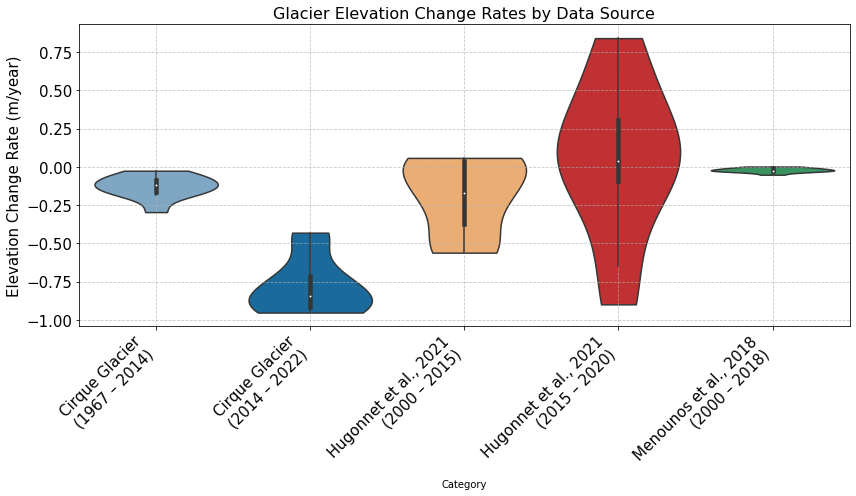

In [9]:
######Cleaner Figure for paper####################
# --- Normalize and standardize dashes to " – " (space–space) format ---
violin_df["Category"] = violin_df["Category"].str.replace("–", " – ", regex=False)           # Replace em dashes with spaced em dashes
violin_df["Category"] = violin_df["Category"].str.replace(" - ", " – ", regex=False)         # Hyphen with space
violin_df["Category"] = violin_df["Category"].str.replace("-", " – ", regex=False)           # Plain hyphen fallback
violin_df["Category"] = violin_df["Category"].str.replace(r"\s+", " ", regex=True).str.strip()  # Remove extra whitespace

# --- Debug: print unique categories after cleaning ---
print("Unique categories after dash normalization:")
print(sorted(violin_df["Category"].unique()))

# --- Update category names for better x-axis formatting ---
violin_df["Category"] = violin_df["Category"].replace({
    "Clean Glacier (1967 – 2014)": "Cirque Glacier\n(1967 – 2014)",
    "Clean Glacier (2014 – 2022)": "Cirque Glacier\n(2014 – 2022)",
    "Hugonnet et al., 2021 (2000 – 2015)": "Hugonnet et al., 2021\n(2000 – 2015)",
    "Hugonnet et al., 2021 (2015 – 2020)": "Hugonnet et al., 2021\n(2015 – 2020)",
    "Menounos et al., 2018 (2000 – 2018)": "Menounos et al., 2018\n(2000 – 2018)"
})



# --- Define custom color palette ---
custom_palette = {
    "Cirque Glacier\n(1967 – 2014)": "#74a9cf",
    "Cirque Glacier\n(2014 – 2022)": "#0570b0",
    "Hugonnet et al., 2021\n(2000 – 2015)": "#fdae61",
    "Hugonnet et al., 2021\n(2015 – 2020)": "#d7191c",
    "Menounos et al., 2018\n(2000 – 2018)": "#2ca25f"
}

# --- Plotting ---
plt.figure(figsize=(12, 7))
sns.violinplot(
    x="Category",
    y="Elevation Change Rate (m/year)",
    data=violin_df,
    palette=custom_palette,
    cut=0,
    scale="width",
    inner="box",
    order=list(custom_palette.keys())  # Ensures palette and order match
)
plt.ylabel("Elevation Change Rate (m/year)", fontsize=15)
plt.xticks(rotation=45, ha='right', fontsize=15)
plt.yticks(fontsize=15)
plt.grid(True, linestyle='--', alpha=0.7)
plt.title("Glacier Elevation Change Rates by Data Source", fontsize=16)
plt.tight_layout()
plt.savefig("glacier change comparision.jpg", format='jpg', dpi=300, bbox_inches='tight')
plt.show()
